In [1]:
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
print(pd.__version__)


1.5.3


<br/>

<br/>

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Relax Data Science Challenge</h3>
</div>

Springboard Take Home Assignment

## <font color=teal>Problem Statement</font>

Overall, we want to gain more understanding of how and why users adopt a given service.  

For this challenge, I'll focus on just the **adoption** approach outlined in the project instructions:  [Instrucions]('./relax_data_science_challenge.pdf')

- Our goal is to determine which users have 'adopted' our service
- In this project we define an adopted user (a user who has adopted our service) as : ```any user who logged in more than twice over any 7-day period``` 
- This could be refined to more specific periods, but for now we are just performing the 7-day adoption definition



## <font color=teal>Scope and Constraints</font>

##### Input data
We are limited to two sets of data:
1. A list of users, including name, email, organization, when they signed up, and how they signed up
2. A list of each time each user logged into our system, incuding the timestamp of the session
3. A set of instructions for the project:   [Instrucions]('./relax_data_science_challenge.pdf')


##### Deliverables
With this project we are creating:

1. <font color=purple>user_activity_df</font> —this dataset joins user activity (takehome_user_engagement) extended with the 7-day rolling sum, to the user activity dataset (takehome_user)
2. <font color=purple>adopting_users_df</font>  --this is just the users who had at least 3 logins in any 7-day period


##### Constraints

This project should be completed in 1-2 hours.   I'm giving it a half a day, but even with that, there's quite a bit more than one might do with this dataset, but I am limiting this exercise to less than 4-5 hours per instructions.
 
- There are some interesting column factors that might correlate or even cause adoption, but for this 2-4 hour exercise I am only addressing the specific factor of login times in a 7 day window
- In the real world, it would be interesting to map how the logins varied over the whole timeline.  Do users login a lot at first then peter out?  Are more recent login more important that old ogins?   
- We are not factoring in the length of time a user has been a member, only whether they logged in 3 times or more during any 7-day period



##### Questions and clarifications

- The data has only one login for any user on any given day.  This is odd because for most applications, there should be cases where a user logged in more than once on a give day
- There is some garbage in some of the text fields in takehome_users.csv that keeps it fraon loading using read_csv().  Rather than trying to find it and fixing, I just created a new textfile called takehome_users_clear.csv
- There is some problem encoding special characters like 'ae' in takehome_users.csv name column.  I tried several different encodings, but it still shows up wrong at least in the Pandas display.  It should be fixed before making this a re-useable dataset


<br/>

---

<br/>


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Read and characterize the activiy data</h3>
</div>


In [41]:
df = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])
df['login_date'] = pd.to_datetime(df['time_stamp'], unit='ns').dt.date
df.head()

,time_stamp,user_id,visited,login_date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


<font color=teal>Let's start by characterizing user activity at a high level</font>
Get all users and their overall session history— their first login (session) and their last as well as overall duration of their membership

The activity data contains 

<font color=purple>two years of sessions data -- user sessions or 'logins' from 5/2012 to 06/2014... about two years</font>

<font color=purple>approximately 208,000 users

In [38]:
df.agg(
    min_time_stamp=('time_stamp', 'min'),
    max_time_stamp=('time_stamp', 'max'),
    users=('user_id', 'count')
).reset_index()

,index,time_stamp,user_id
0,min_time_stamp,2012-05-31 08:20:06,NaN
1,max_time_stamp,2014-06-06 14:58:50,NaN
2,users,NaT,207917.00


Let's break that down by user

In [39]:
activity_summary_df = df.groupby(['user_id']).agg(
    min_time_stamp=('time_stamp', 'min'),
    max_time_stamp=('time_stamp', 'max'),
    visits=('visited', 'sum')
).reset_index()

activity_summary_df['duration_days'] = (activity_summary_df['max_time_stamp'] - activity_summary_df['min_time_stamp']).dt.days



<font color=purple>A good proportion of users login right away then don't return (their duration as an active member is less than a few days)</font>

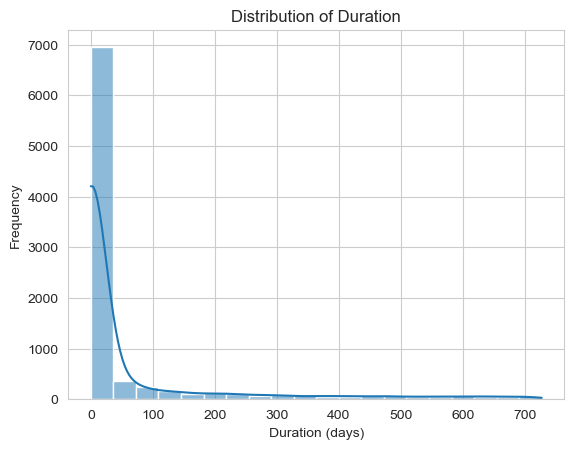

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming activity_summary_df already contains the 'duration_hours' column
sns.histplot(data=activity_summary_df, x='duration_days', bins=20, kde=True)
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Duration')
plt.show()


<font color=purple>Activity increases over the 2012 - 2014 time span</font>

The activity data shows a gradual positive increase in user activity between 2012 and 2014
This does not necessarily mean there are more users, only that there was more user activity 

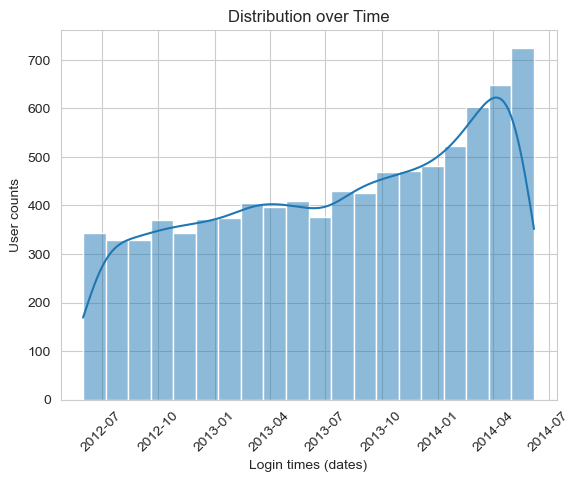

In [6]:
# Assuming activity_summary_df already contains the 'duration_hours' column
sns.histplot(data=activity_summary_df, x='min_time_stamp', bins=20, kde=True)
plt.xlabel('Login times (dates)')
plt.ylabel('User counts')
plt.title('Distribution over Time')
plt.xticks(rotation=45)
plt.show()


<font color=purple>Each row represents a single visit</font>

Validate that there are no rows with more tha one visited count

In [7]:
# only one visit per row
n = df.visited.value_counts()
assert n[1] == df.shape[0]


<br/>

<font color=purple>There's only one visit per user per day</font>

Below, we validate that there are no rows with more than one visited count
 
this is odd because for most applications, there should be cases where a user logged in twice on a give day

In [8]:
counts = df.groupby(['user_id', 'login_date']).size().reset_index(name='count')
duplicate_rows = counts[counts['count'] > 1]

assert duplicate_rows.shape[0] == 0

<br/>

---

<br/>


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">What is a rolling window?</h3>
</div>

As an example, we are going to demonstrate a 4-day window to keep it simple.   during a 7-day period our user logged in once per day for days one through 4, then did not login in again

The chart below shows 
- the seven days across the top header
- a logins column that has a 1 for every actual login and a 0 if the user did not log in
- a rolling sum columns that shows our rolling sum

<br/>


##### In the chart below, on day 4 the user had logged in once a day for the past four days so the sum in this column is 4
##### But on day 5, the user did not log in, so the rolling sum is the sum of days 2 through 5 (four days) which is 3
##### And on day 6, the user also did not log in, so the rolling sum is the sum of days 3 through 6 (four days) which is 2

<br/>


| Days        | 1 | 2 | 3 | 4  | 5 | 6 | 7   |
|-------------|---|---|---|----|---|---|-----|
| logins      | 1 | 1 | 1 | 1  | 0 | 0 | 0   |
| rolling sum | 1 | 2 | 3 | 4 | 3 | 2 | 1   |





<font color=teal>Let's take a sample of a single user </font>

We can see that user_id 2 logged in only once in any given period before 12/25/2013 so the rolling sums of 11/15/2013 through 12/09/2013 will be 1
Then the user logged in on 12/25/2013, then again 7 days later, so the rolling sum for that 7-day window should be 2
We will be able to see this when we create the rolling window

In [42]:

df.loc[df['user_id']==2].sort_values(by=['time_stamp'])

,time_stamp,user_id,visited,login_date
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
5,2013-12-31 03:45:04,2,1,2013-12-31
6,2014-01-08 03:45:04,2,1,2014-01-08
7,2014-02-03 03:45:04,2,1,2014-02-03
8,2014-02-08 03:45:04,2,1,2014-02-08
9,2014-02-09 03:45:04,2,1,2014-02-09
10,2014-02-13 03:45:04,2,1,2014-02-13


<br/>

---


<br/>


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Create the rolling window</h3>
</div>



<font color=teal>Use pandas built-in rolling() function</font>

Next, we'll create a new column called "rolling_visits" that contains the rolling sum 

In [43]:
df.index = pd.DatetimeIndex(df['login_date'])

window_size = '7D'
df['rolling_visits'] = (df.groupby('user_id')['visited']
                             .rolling(window=window_size)
                             .sum()
                             .reset_index(level=0, drop=True))

In [44]:
df.head()

,time_stamp,user_id,visited,login_date,rolling_visits
login_date,,,,,
2014-04-22,2014-04-22 03:53:30,1,1,2014-04-22,1.00
2013-11-15,2013-11-15 03:45:04,2,1,2013-11-15,1.00
2013-11-29,2013-11-29 03:45:04,2,1,2013-11-29,1.00
2013-12-09,2013-12-09 03:45:04,2,1,2013-12-09,1.00
2013-12-25,2013-12-25 03:45:04,2,1,2013-12-25,1.00


<font color=teal>Let's take a look at user_id 2 again</font>

We should still have 14 rows, but take a look at the data for user 2
As expected, the rolling_visits sum is 1 for every day until 12/31/2013, when it is 2.
The user logged in twice during the window between 12/25/2013 and 12/31/2013

In [45]:
df.loc[df['user_id']==2].sort_values(by=['time_stamp'])

,time_stamp,user_id,visited,login_date,rolling_visits
login_date,,,,,
2013-11-15,2013-11-15 03:45:04,2,1,2013-11-15,1.00
2013-11-29,2013-11-29 03:45:04,2,1,2013-11-29,1.00
2013-12-09,2013-12-09 03:45:04,2,1,2013-12-09,1.00
2013-12-25,2013-12-25 03:45:04,2,1,2013-12-25,1.00
2013-12-31,2013-12-31 03:45:04,2,1,2013-12-31,2.00
2014-01-08,2014-01-08 03:45:04,2,1,2014-01-08,1.00
2014-02-03,2014-02-03 03:45:04,2,1,2014-02-03,1.00
2014-02-08,2014-02-08 03:45:04,2,1,2014-02-08,2.00
2014-02-09,2014-02-09 03:45:04,2,1,2014-02-09,3.00


<font color=teal>Now let's pull out just the users who had more than 3 session in any 7-day window</font>

We'll put them in a new dataset called ```adopting_users_df```

In [46]:
adopting_users_df = df.loc[ df['rolling_visits']>=3].groupby('user_id').agg(
    {'login_date': 'max', 'rolling_visits': 'max'}
).sort_values(by=['rolling_visits'], ascending=False)



<font color=teal>The rolling sums range between 4 and 7 with half the users having 7 visits</font>

We know that the constraint in the date keeps users from having any more than 7 daya in any given rolling sum, and that's still a concern
We can see that 621 users had a 7-day streak, 237 users had 6 logins, 223 users had a 5, and 216 users had four, and 305 users had 3 visits in a 7-day period

In [47]:
print("How many users do we have for each rolling sum (how_many_visits)")
n = adopting_users_df['rolling_visits'].value_counts().reset_index()
n = n.rename(columns={'rolling_visits': 'how_many_users', 'index': 'how_many_visits'})
n.sort_values('how_many_visits', ascending=False)

How many users do we have for each rolling sum (how_many_visits)


,how_many_visits,how_many_users
0,7.00,621
2,6.00,237
3,5.00,223
4,4.00,216
1,3.00,305


<font color=teal>Merge user information into our rolling sums data</font>

Let's assume we want to store this wonderful information in a new dataset.   We'll want to be able to see who these users are, and maybe even slice across some other user characteristics
We'll do that now using the takehome_users.csv dataset

First, load the user data as 'signups_df'

In [48]:
signups_df = (pd.read_csv("takehome_users_clear.csv",  encoding='utf-8', parse_dates=['creation_time'])
              .rename(columns={"object_id": "user_id"}))
signups_df['last_session_creation_time'] = pd.to_datetime(signups_df['last_session_creation_time'], unit='ns')
signups_df.head()



,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.00
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.00
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.00
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.00
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.00


Now merge the user data with the data that we added the rolling sums to.

<br/>

Recall that we first added a rolling sum to the whole activity dataset, THEN we filtered out just the adopting users.

<br/>

But here we do not want to use the 'adopted users' data set 

<br/>


Instead, we want to merge user information with **all** the data, but with the new rolling_vists column

In [50]:
merge_df = pd.merge(signups_df, df, on=["user_id"], how='outer', indicator=True)
merge_df['_merge'].value_counts()

both          207917
left_only       3177
right_only         0
Name: _merge, dtype: int64

<br/>


The value_counts query above shows us that there are 3,177 users who signed up, but never had any logins during the 2012 - 2014 period.

We could leave them as they are, but we'd then have null values that might trip someone up later, so let's instead perform the following logic:

For all intents and purposes, a user who never logged in after signing up still had at least one session when they registered for the service, so we can safely set their timestamp and login date to the date they signed up.
We can change the visited column to 'vists_after_signup' and set it to zero for users who never logged in again.
And we can change the 'rolling_visits' to 'seven_day_sum' so it's clear what window we are summing over



In [51]:
# Create columns 'visited', 'time_stamp', and 'login_date' based on the condition
merge_df['visited'] = np.where(merge_df['_merge'] == 'left_only', 0, merge_df['visited'])
merge_df['time_stamp'] = np.where(merge_df['_merge'] == 'left_only', merge_df['creation_time'], merge_df['time_stamp'])
merge_df['login_date'] = np.where(merge_df['_merge'] == 'left_only', pd.to_datetime(merge_df['creation_time'], unit='ns').dt.date, merge_df['login_date'])
merge_df.rename(columns={'visited':'vists_after_signup', 'rolling_visits': 'seven_day_sum'}, inplace=True)



<br/>

Let's take a quick look at the merge dataset now.

In [52]:
merge_df.loc[merge_df['_merge'] =='left_only'].head()


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,vists_after_signup,login_date,seven_day_sum,_merge
20,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,2013-07-31 05:34:02,0.00,2013-07-31,NaN,left_only
21,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,2013-11-05 04:04:24,0.00,2013-11-05,NaN,left_only
307,12,2014-04-17 23:48:38,Mathiesen L�rke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.00,2014-04-17 23:48:38,0.00,2014-04-17,NaN,left_only
310,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,2013-07-16 21:33:54,0.00,2013-07-16,NaN,left_only
311,16,2013-02-11 10:09:50,Engel Ren�,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,2013-02-11 10:09:50,0.00,2013-02-11,NaN,left_only


<br/>

And we no longer need our _merge column, so we drop it, and we re going to keep this dataframe so let's rename it to "user_activity_df"

<br/>

In [53]:
merge_df.drop('_merge', axis=1, inplace=True)
user_activity_df = merge_df